In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as optim
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

In [3]:
pl.seed_everything(42)

Seed set to 42


42

In [4]:
X_train=pd.read_csv('X_train.csv')
y_train=pd.read_csv('y_train.csv')

In [5]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [6]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


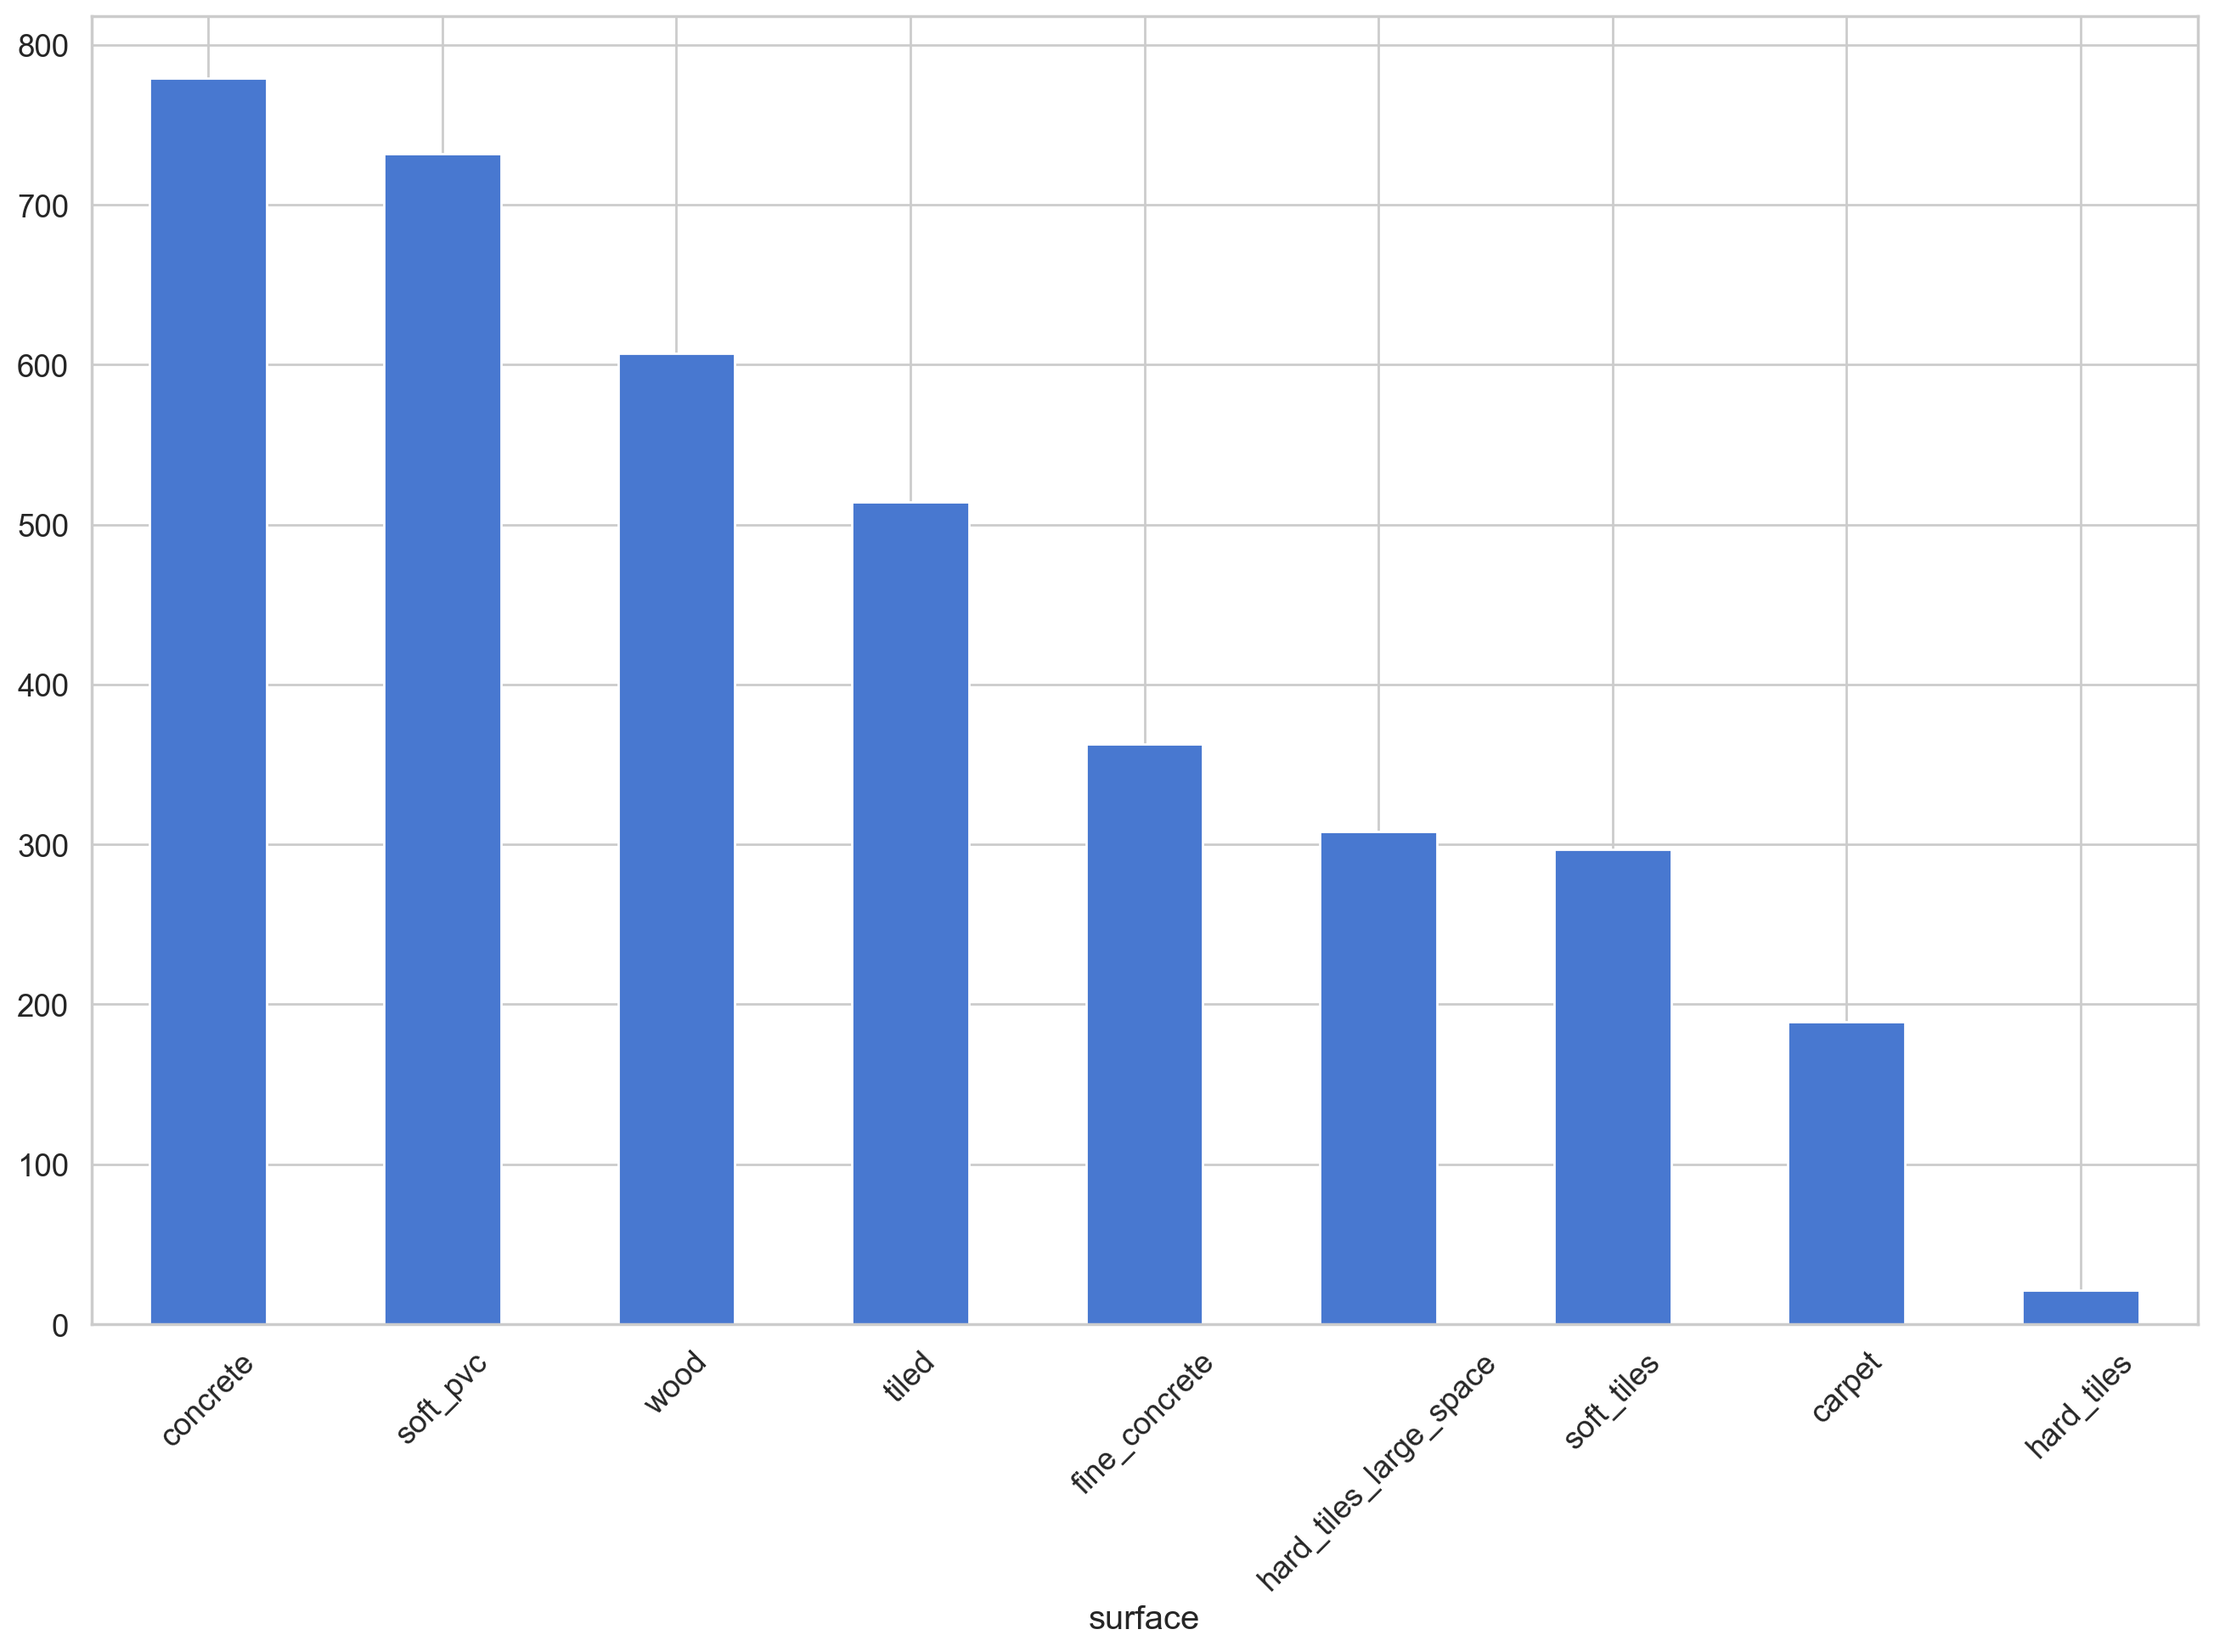

In [7]:
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

# might do resampling as the classes are not equally available

# Preprocessing the data

In [8]:
label_encoder=LabelEncoder()
encoded_labels=label_encoder.fit_transform(y_train.surface)

In [9]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [10]:
y_train["label"]=encoded_labels

In [11]:
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [12]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [13]:
FEATURE_COLS=X_train.columns.tolist()[3:]
FEATURE_COLS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [14]:
X_train.series_id.value_counts()

series_id
0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: count, Length: 3810, dtype: int64

All the series are segmented into 128 points and these ahve the labels for them

In [15]:
(X_train.series_id.value_counts()==128).sum()==len(y_train)

True

In [16]:
sequences=[]
for series_id,group in X_train.groupby("series_id"):
    sequence_features=group[FEATURE_COLS]
    label=y_train[y_train.series_id==series_id].iloc[0].label
    
    sequences.append((sequence_features,label))
    

What we did is that we made the difference 3810 sequences together. that is below given data is the difference orientations of the group given by series id 0

In [17]:
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

In [18]:
train_sequences,test_sequences=train_test_split(sequences,test_size=0.2)

In [19]:
len(train_sequences), len(test_sequences)

(3048, 762)

# Dataset

from torch.nn.utils.rnn import pad_sequence
class SurfaceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        
        # Assuming `sequence` is a pandas DataFrame or numpy array, convert to Tensor
        sequence_tensor = torch.Tensor(sequence.to_numpy()) if isinstance(sequence, pd.DataFrame) else torch.Tensor(sequence)
        
        # Pad sequence to make sure all sequences are the same length
        padded_sequence = pad_sequence([sequence_tensor], batch_first=True, padding_value=0.0)
        
        return dict(
            sequence=padded_sequence[0],  # Extract the padded tensor
            label=torch.tensor(label).long()
        )

In [20]:
class SurfaceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
        label=torch.tensor(label).long()
    )

In [21]:
class SurfaceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
    
    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)


In [22]:
N_EPOCHS = 260
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences,test_sequences,BATCH_SIZE)

MODEL DEVELOPING

In [23]:
class SequenceModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=260, n_layers=3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75
        )
        
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        return self.classifier(out)


In [36]:
class SurfacePredictor(pl.LightningModule):
    
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        
        # Using torchmetrics for accuracy computation
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=n_classes)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=n_classes)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=n_classes)
        
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = self.train_accuracy(predictions, labels)
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = self.val_accuracy(predictions, labels)
        
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = self.test_accuracy(predictions, labels)
        
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)


In [37]:
model=SurfacePredictor(n_features=len(FEATURE_COLS),
                       n_classes=len(label_encoder.classes_))

In [38]:
%load_ext tensorboard
%tensorboard --logdir=lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 6212), started 0:20:56 ago. (Use '!kill 6212' to kill it.)

In [39]:
# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

# Logger setup
logger = TensorBoardLogger("lightning_logs", name="surface")

# Trainer setup
trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EPOCHS,
    devices="auto",
    accelerator="gpu",
    enable_progress_bar=True
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(model,data_module)

/Users/spandy/miniforge3/envs/deep/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Volumes/Personal/projects/time-series/career-con-2019/checkpoints exists and is not empty.

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | SequenceModel      | 1.4 M  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.484     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/spandy/miniforge3/envs/deep/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/spandy/miniforge3/envs/deep/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/spandy/miniforge3/envs/deep/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 48: 'val_loss' reached 2.02768 (best 2.02768), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 96: 'val_loss' reached 2.01990 (best 2.01990), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 144: 'val_loss' reached 2.01059 (best 2.01059), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 192: 'val_loss' reached 1.92308 (best 1.92308), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 240: 'val_loss' reached 1.86738 (best 1.86738), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 288: 'val_loss' reached 1.84942 (best 1.84942), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 336: 'val_loss' reached 1.74473 (best 1.74473), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 384: 'val_loss' reached 1.69950 (best 1.69950), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 432: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 480: 'val_loss' reached 1.66383 (best 1.66383), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 528: 'val_loss' reached 1.62348 (best 1.62348), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 576: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 624: 'val_loss' reached 1.58614 (best 1.58614), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 672: 'val_loss' reached 1.58162 (best 1.58162), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 720: 'val_loss' reached 1.53071 (best 1.53071), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 768: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 816: 'val_loss' reached 1.46244 (best 1.46244), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 864: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 912: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 960: 'val_loss' reached 1.42426 (best 1.42426), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1008: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1056: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1104: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1152: 'val_loss' reached 1.39470 (best 1.39470), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1248: 'val_loss' reached 1.38309 (best 1.38309), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1296: 'val_loss' reached 1.34762 (best 1.34762), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1344: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1392: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1440: 'val_loss' reached 1.29177 (best 1.29177), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 1488: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 1536: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 1584: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 1632: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 1680: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 1728: 'val_loss' reached 1.22551 (best 1.22551), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 1776: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 1824: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 1872: 'val_loss' reached 1.20895 (best 1.20895), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 1920: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 1968: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 2016: 'val_loss' reached 1.16880 (best 1.16880), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 2064: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 2112: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 2160: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 2208: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 2256: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 2304: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 2352: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 2400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 2448: 'val_loss' reached 1.08268 (best 1.08268), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 2496: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 2544: 'val_loss' reached 1.07401 (best 1.07401), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 2592: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 2640: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 2688: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 2736: 'val_loss' reached 1.07396 (best 1.07396), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 2784: 'val_loss' reached 1.03025 (best 1.03025), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 2832: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 2880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 2928: 'val_loss' reached 1.02517 (best 1.02517), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 2976: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 3024: 'val_loss' reached 1.02248 (best 1.02248), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 3072: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 3120: 'val_loss' reached 0.98826 (best 0.98826), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 3168: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 3216: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 3264: 'val_loss' reached 0.94662 (best 0.94662), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 3312: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 3360: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 3408: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 3456: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 3504: 'val_loss' reached 0.90453 (best 0.90453), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 3552: 'val_loss' reached 0.86405 (best 0.86405), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 3600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 3648: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 3696: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 3744: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 3792: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 3840: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 3888: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 3936: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 3984: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 4032: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 4080: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 4128: 'val_loss' reached 0.83488 (best 0.83488), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 4176: 'val_loss' reached 0.79312 (best 0.79312), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 4224: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 4272: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 4320: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 4368: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 4416: 'val_loss' reached 0.79215 (best 0.79215), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 4464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 4512: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 4560: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 4608: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 4656: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 4704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 4752: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 4800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 100, global step 4848: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 101, global step 4896: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 102, global step 4944: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 103, global step 4992: 'val_loss' reached 0.77302 (best 0.77302), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 104, global step 5040: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 105, global step 5088: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 106, global step 5136: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 107, global step 5184: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 108, global step 5232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 109, global step 5280: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 110, global step 5328: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 111, global step 5376: 'val_loss' reached 0.73083 (best 0.73083), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 112, global step 5424: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 113, global step 5472: 'val_loss' reached 0.73056 (best 0.73056), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 114, global step 5520: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 115, global step 5568: 'val_loss' reached 0.70980 (best 0.70980), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 116, global step 5616: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 117, global step 5664: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 118, global step 5712: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 119, global step 5760: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 120, global step 5808: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 121, global step 5856: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 122, global step 5904: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 123, global step 5952: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 124, global step 6000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 125, global step 6048: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 126, global step 6096: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 127, global step 6144: 'val_loss' reached 0.70439 (best 0.70439), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 128, global step 6192: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 129, global step 6240: 'val_loss' reached 0.70001 (best 0.70001), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 130, global step 6288: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 131, global step 6336: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 132, global step 6384: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 133, global step 6432: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 134, global step 6480: 'val_loss' reached 0.69737 (best 0.69737), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 135, global step 6528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 136, global step 6576: 'val_loss' reached 0.68260 (best 0.68260), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 137, global step 6624: 'val_loss' reached 0.65780 (best 0.65780), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 138, global step 6672: 'val_loss' reached 0.65385 (best 0.65385), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 139, global step 6720: 'val_loss' reached 0.64161 (best 0.64161), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 140, global step 6768: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 141, global step 6816: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 142, global step 6864: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 143, global step 6912: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 144, global step 6960: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 145, global step 7008: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 146, global step 7056: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 147, global step 7104: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 148, global step 7152: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 149, global step 7200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 150, global step 7248: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 151, global step 7296: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 152, global step 7344: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 153, global step 7392: 'val_loss' reached 0.63758 (best 0.63758), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 154, global step 7440: 'val_loss' reached 0.63075 (best 0.63075), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 155, global step 7488: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 156, global step 7536: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 157, global step 7584: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 158, global step 7632: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 159, global step 7680: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 160, global step 7728: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 161, global step 7776: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 162, global step 7824: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 163, global step 7872: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 164, global step 7920: 'val_loss' reached 0.62996 (best 0.62996), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 165, global step 7968: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 166, global step 8016: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 167, global step 8064: 'val_loss' reached 0.60989 (best 0.60989), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 168, global step 8112: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 169, global step 8160: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 170, global step 8208: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 171, global step 8256: 'val_loss' reached 0.59605 (best 0.59605), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 172, global step 8304: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 173, global step 8352: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 174, global step 8400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 175, global step 8448: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 176, global step 8496: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 177, global step 8544: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 178, global step 8592: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 179, global step 8640: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 180, global step 8688: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 181, global step 8736: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 182, global step 8784: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 183, global step 8832: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 184, global step 8880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 185, global step 8928: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 186, global step 8976: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 187, global step 9024: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 188, global step 9072: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 189, global step 9120: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 190, global step 9168: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 191, global step 9216: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 192, global step 9264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 193, global step 9312: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 194, global step 9360: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 195, global step 9408: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 196, global step 9456: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 197, global step 9504: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 198, global step 9552: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 199, global step 9600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 200, global step 9648: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 201, global step 9696: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 202, global step 9744: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 203, global step 9792: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 204, global step 9840: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 205, global step 9888: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 206, global step 9936: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 207, global step 9984: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 208, global step 10032: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 209, global step 10080: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 210, global step 10128: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 211, global step 10176: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 212, global step 10224: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 213, global step 10272: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 214, global step 10320: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 215, global step 10368: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 216, global step 10416: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 217, global step 10464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 218, global step 10512: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 219, global step 10560: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 220, global step 10608: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 221, global step 10656: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 222, global step 10704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 223, global step 10752: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 224, global step 10800: 'val_loss' reached 0.57949 (best 0.57949), saving model to '/Volumes/Personal/projects/time-series/career-con-2019/checkpoints/best-checkpoint-v11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 225, global step 10848: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 226, global step 10896: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 227, global step 10944: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 228, global step 10992: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 229, global step 11040: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 230, global step 11088: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 231, global step 11136: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 232, global step 11184: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 233, global step 11232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 234, global step 11280: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 235, global step 11328: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 236, global step 11376: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 237, global step 11424: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 238, global step 11472: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 239, global step 11520: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 240, global step 11568: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 241, global step 11616: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 242, global step 11664: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 243, global step 11712: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 244, global step 11760: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 245, global step 11808: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 246, global step 11856: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 247, global step 11904: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 248, global step 11952: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 249, global step 12000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 250, global step 12048: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 251, global step 12096: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 252, global step 12144: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 253, global step 12192: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 254, global step 12240: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 255, global step 12288: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 256, global step 12336: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 257, global step 12384: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 258, global step 12432: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 259, global step 12480: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=260` reached.


In [41]:
model=SurfacePredictor.load_from_checkpoint("checkpoints/best-checkpoint-v11.ckpt",n_features=len(FEATURE_COLS),
                       n_classes=len(label_encoder.classes_))

In [42]:
trainer.test(model,data_module)

/Users/spandy/miniforge3/envs/deep/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8149606585502625     │
│         test_loss         │    0.5794905424118042     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5794905424118042, 'test_accuracy': 0.8149606585502625}]

In [43]:
model.freeze()

In [44]:
test_dataset=SurfaceDataset(test_sequences)
predictions=[]
labels=[]

for item in tqdm(test_dataset):
    sequence=item["sequence"]
    label=item["label"]
    
    _,output=model(sequence.unsqueeze(dim=0))
    prediction=torch.argmax(output, dim=1)
    predictions.append(prediction.item())
    labels.append(label.item())

  0%|          | 0/762 [00:00<?, ?it/s]

In [45]:
print(
    classification_report(labels,predictions,target_names=label_encoder.classes_)
)

                        precision    recall  f1-score   support

                carpet       0.74      0.72      0.73        47
              concrete       0.82      0.84      0.83       172
         fine_concrete       0.69      0.66      0.68        65
            hard_tiles       0.80      0.80      0.80         5
hard_tiles_large_space       0.92      0.75      0.82        63
              soft_pvc       0.87      0.90      0.89       141
            soft_tiles       0.89      0.94      0.91        63
                 tiled       0.77      0.81      0.79        89
                  wood       0.78      0.78      0.78       117

              accuracy                           0.81       762
             macro avg       0.81      0.80      0.80       762
          weighted avg       0.82      0.81      0.81       762



In [46]:
def show_confusion_matrix(confusion_matrix):
    hmap=sns.heatmap(confusion_matrix,annot=True,fmt="d",cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0,ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30,ha='right')
    plt.ylabel('True surface')
    plt.xlabel('Predicted Surface')

In [47]:
cm=confusion_matrix(labels,predictions)
df_cm=pd.DataFrame(
    cm,index=label_encoder.classes_,columns=label_encoder.classes_
)
df_cm

,carpet,concrete,fine_concrete,hard_tiles,hard_tiles_large_space,soft_pvc,soft_tiles,tiled,wood
carpet,34,8,1,0,1,0,0,1,2
concrete,5,144,2,0,1,3,1,10,6
fine_concrete,0,8,43,0,1,5,0,2,6
hard_tiles,0,0,0,4,0,0,0,0,1
hard_tiles_large_space,1,3,7,0,47,1,0,0,4
soft_pvc,2,2,2,0,0,127,3,2,3
soft_tiles,0,0,1,0,0,1,59,2,0
tiled,1,7,3,0,0,2,0,72,4
wood,3,3,3,1,1,7,3,5,91


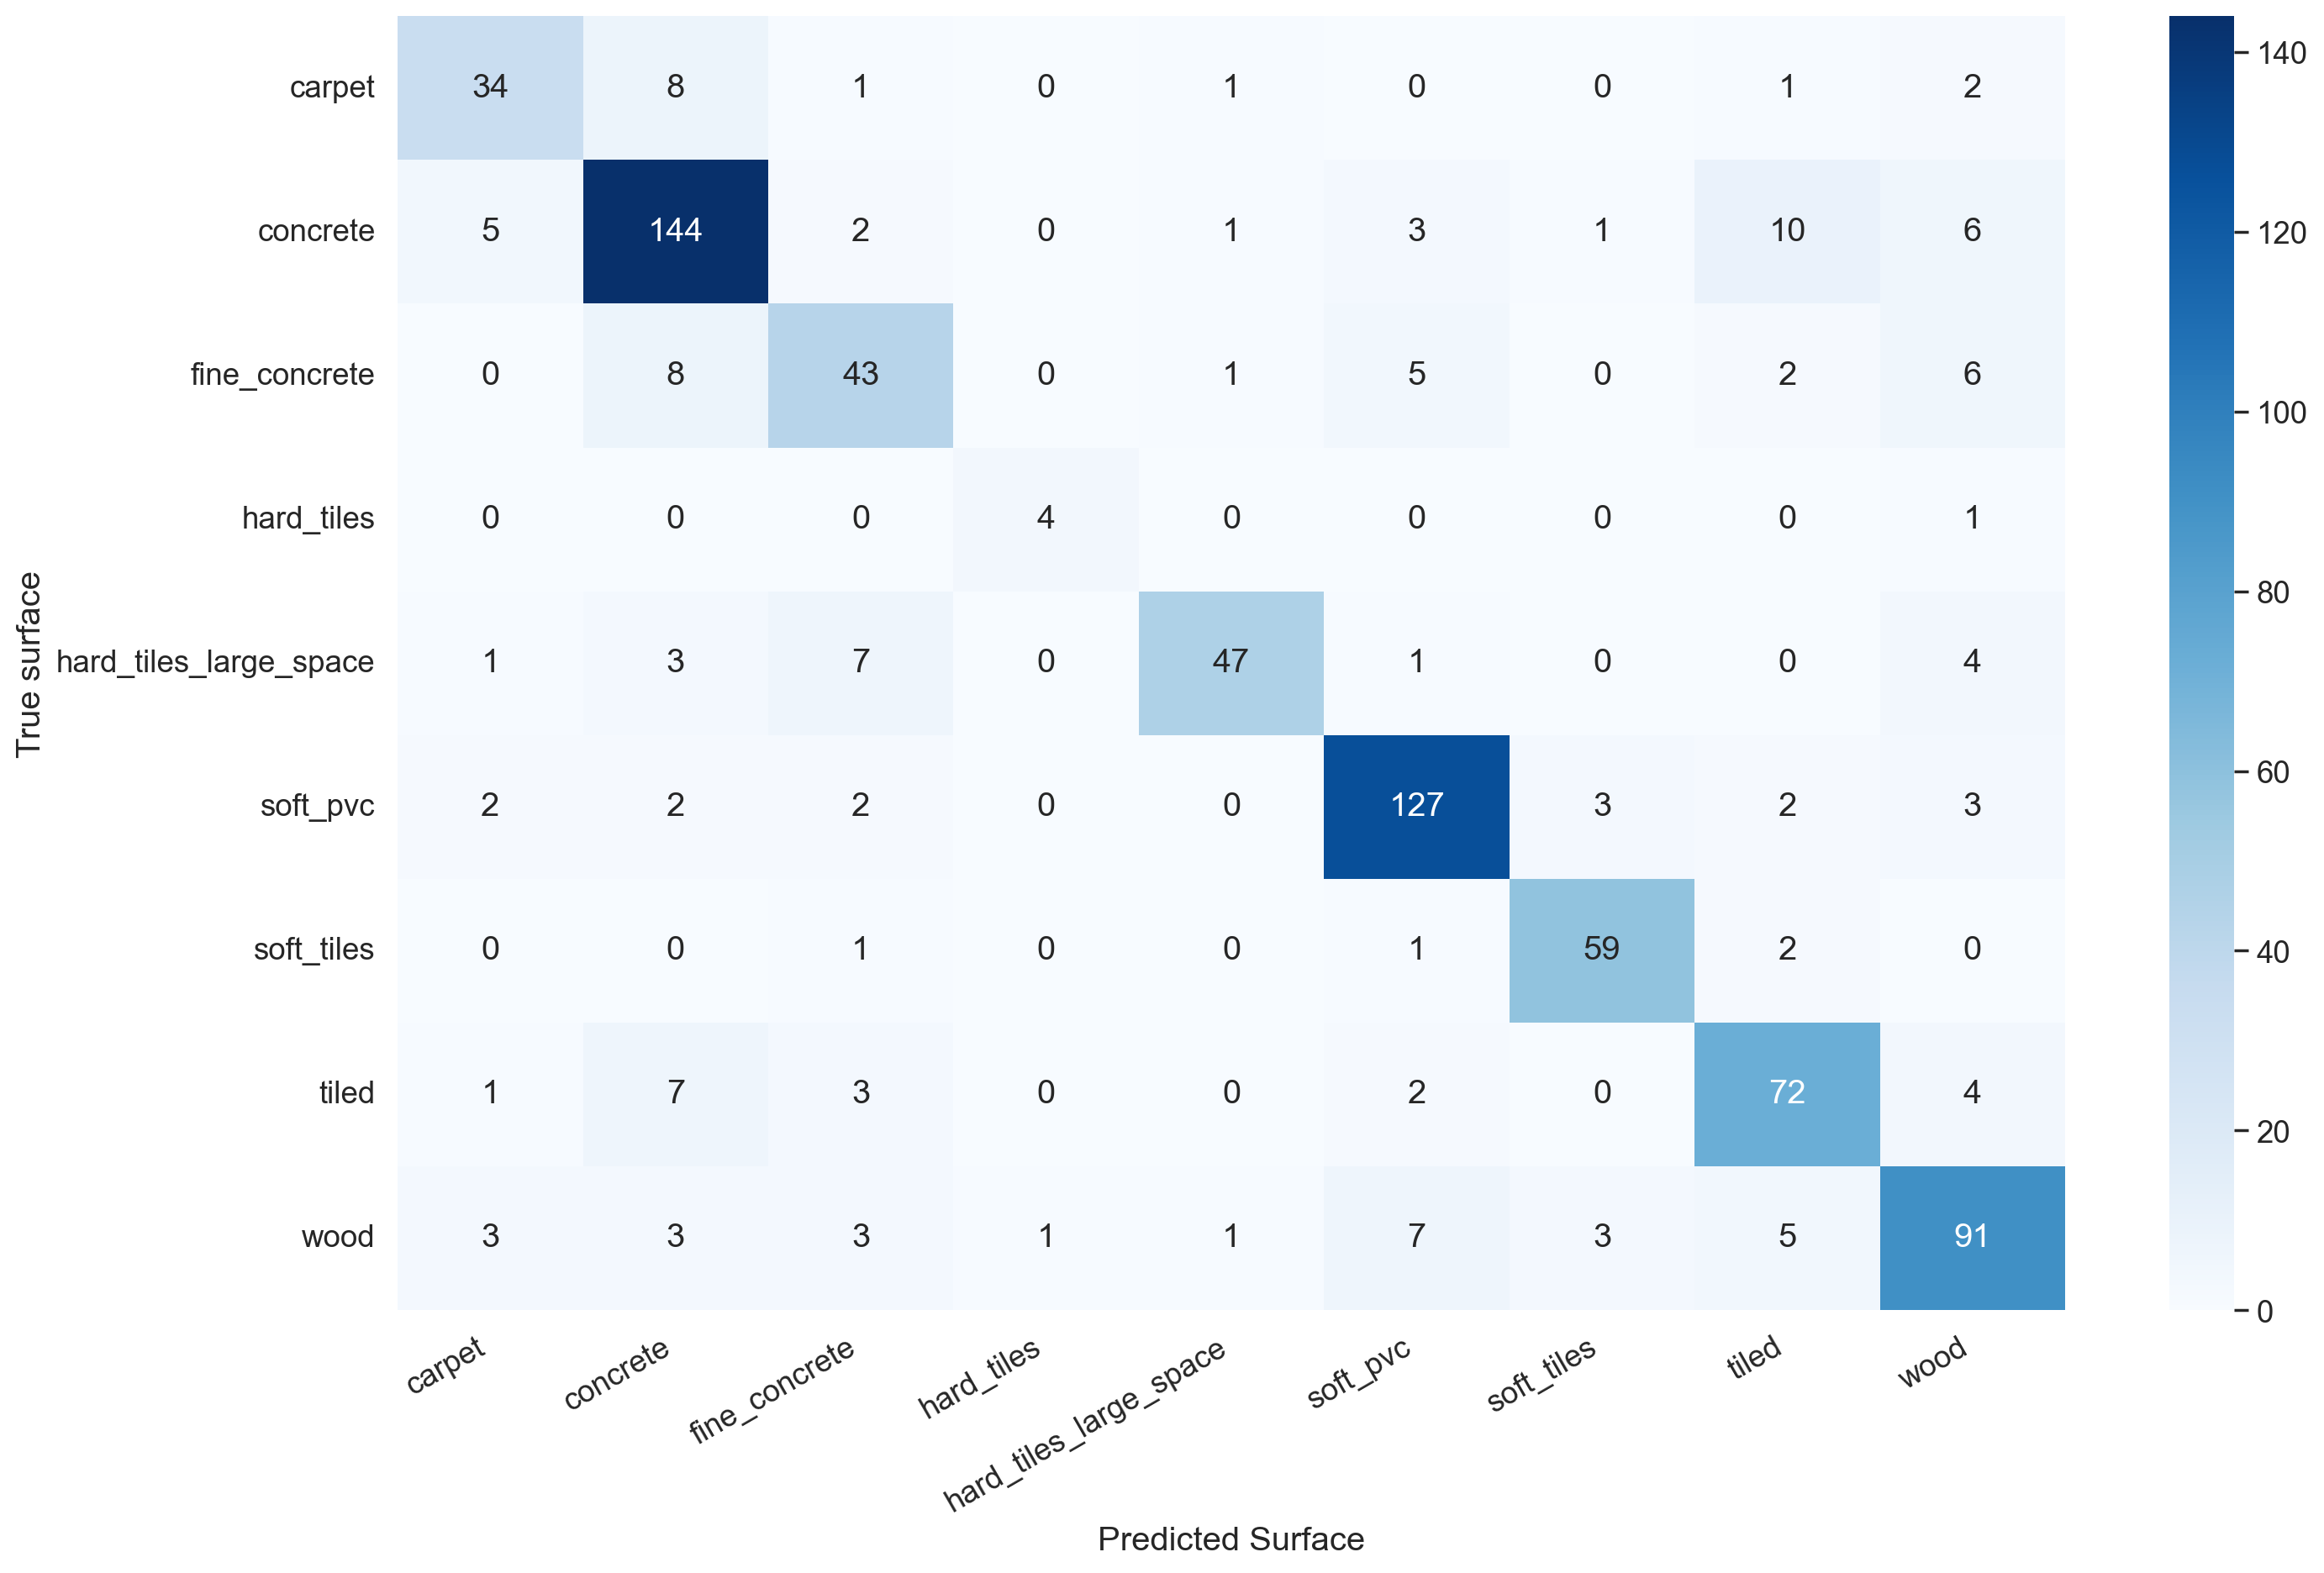

In [48]:
show_confusion_matrix(df_cm)